In [63]:
%load_ext autoreload
%autoreload 2 #make sure to automatically load externally updated files
import os
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,MaxAbsScaler,OneHotEncoder
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import r2_score
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from helper_xiang import *
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_squared_log_error
import math
from sklearn.preprocessing import StandardScaler,MaxAbsScaler,OneHotEncoder
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit, cross_val_score,cross_validate,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.metrics import balanced_accuracy_score,precision_score,recall_score
from sklearn.svm import SVC
from pandas.plotting import scatter_matrix
from lightgbm import LGBMRegressor

def print_info(variable_name):
    print("---", variable_name, "     type = ", type(eval(variable_name)), "     Value = ", eval(variable_name)," --- ")

def print_infos(*variable_names):
    """
        Prints information about the variables

        Example: print_infos('var1','var2')
    """
    for variable_name in variable_names:
        print("---", variable_name, "     type = ", type(eval(variable_name)), "     Value = ", eval(variable_name)," --- ")

def print_types(*variable_names,print_shape=True):
    """
        Prints types about the variables

        :param print_shape(bool): Prints shape of variables (Needs them to be a np array, DataFrame or Series)

        Example: print_types('var1','var2')
    """
    for variable_name in variable_names:
        if not print_shape:
            print("---", variable_name, "     type = ", type(eval(variable_name)))
        if print_shape:
            print("---", variable_name, "     type = ", type(eval(variable_name)),end="") #makes to to not have a new line
            try:
                print("     Shape = ", eval(variable_name).shape," --- \n")
            except:
                pass


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load Data

In [64]:
data=pd.read_csv("./data/trainset.csv")
if False:
    data.head(10000).to_excel("./data/trainset.xlsx")
data=data.drop(["index"],axis=1)

data['error'] = (data['error_category'] != 'NO_ERROR').astype(int)

data_full=pd.read_csv("./data/trainset_full.csv")
data_full=data_full.drop(["index"],axis=1)

In [98]:
features_with_nan=['wind_speed', 'power', 'rotor_speed', 'generator_speed', 'temp_environment', 'temp_hydraulic_oil', 'temp_gear_bearing', 'blade_angle_avg']

col_num=data.select_dtypes(include=["float64","int64"]).columns
print_info('col_num')

error_cats=list(data["error_category"].unique())
print_info('error_cats')





--- col_num      type =  <class 'pandas.core.indexes.base.Index'>      Value =  Index(['turbine_id', 'wind_speed', 'power', 'nacelle_direction',
       'wind_direction', 'rotor_speed', 'generator_speed', 'temp_environment',
       'temp_hydraulic_oil', 'temp_gear_bearing', 'cosphi', 'blade_angle_avg',
       'hydraulic_pressure', 'park_id'],
      dtype='object')  --- 
--- error_cats      type =  <class 'list'>      Value =  ['NO_ERROR', 'ERROR=5', 'ERROR=22', 'ERROR=7', 'ERROR=3', 'ERROR=24', 'ERROR=19', 'ERROR=8', 'ERROR=20', 'ERROR=28', 'ERROR=31', 'ERROR=27', 'ERROR=23', 'ERROR=29', 'ERROR=12', 'ERROR=30', 'ERROR=17', 'ERROR=25']  --- 


In [113]:
data["error_category"]=data["error_category"].replace("ERROR=3","3_unplanned_maintainance")
data["error_category"]=data["error_category"].replace("ERROR=5","5_TSO_curtailment")
data["error_category"]=data["error_category"].replace("ERROR=7","7_other_grid_curtailment")
data["error_category"]=data["error_category"].replace("ERROR=8","8_gen_environm_curtailment")
data["error_category"]=data["error_category"].replace("ERROR=12","12_noisce_reduction")
data["error_category"]=data["error_category"].replace("ERROR=22","22_grid_failures")
data["error_category"]=data["error_category"].replace("ERROR=24","24_untwist")
data["error_category"]=data["error_category"].replace("ERROR=19","19_other_tech_failure")
data["error_category"]=data["error_category"].replace("ERROR=20","20_warning")
data["error_category"]=data["error_category"].replace("ERROR=28","28_ptich_system_failure")
data["error_category"]=data["error_category"].replace("ERROR=31","31_converter_failure")
data["error_category"]=data["error_category"].replace("ERROR=27","27_yawing_system_failure")
data["error_category"]=data["error_category"].replace("ERROR=23","23_others")
data["error_category"]=data["error_category"].replace("ERROR=29","29_drivetrain_failure")
data["error_category"]=data["error_category"].replace("ERROR=30","30_generator_failure")
data["error_category"]=data["error_category"].replace("ERROR=17","17_low_wind_speed")
data["error_category"]=data["error_category"].replace("ERROR=25","25_measurement/sensor_error")

print(data["error_category"].value_counts())

#reshuffle rows
data3=data.sample(frac=1)

NO_ERROR                       1272609
12_noisce_reduction              47724
17_low_wind_speed                21651
3_unplanned_maintainance         10224
5_TSO_curtailment                 4893
19_other_tech_failure             3743
24_untwist                        1771
28_ptich_system_failure           1494
8_gen_environm_curtailment        1081
20_warning                         787
31_converter_failure               495
30_generator_failure               409
22_grid_failures                   141
25_measurement/sensor_error        108
7_other_grid_curtailment            32
27_yawing_system_failure            22
29_drivetrain_failure                4
23_others                            2
Name: error_category, dtype: int64


In [109]:
"""
    Predict one feature using others. D
"""
action=1
match action:
    case 1:
        features_to_be_imputed=features_with_nan
    case 2:
        features_to_be_imputed=["temp_hydraulic_oil"]

model=LGBMRegressor()

for feature_to_be_imputed in features_to_be_imputed:
    print("-- Starting with ", feature_to_be_imputed)

    #Get DataFram where there is no NaN values in this column
    data_without_nan=get_data_without_nan(data,feature_to_be_imputed)

    X,y=create_X_y_for_single_feature_imputation(data_full,feature_to_be_imputed)


    action=2
    match action:
        #Evaluate using single train test split
        case 1:
            X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.5)
            #print_types("X_train","X_test","y_train","y_test") #print shapes

            model.fit(X_train,y_train)
            y_pred=model.predict(X_test)
            score=r2_score(y_test,y_pred)
            print(score,feature_to_be_imputed)
        #Evaluate using CV
        case 2:
            kfold = KFold(n_splits=8, shuffle=True)
            score_dict=cross_validate(model,X,y,cv=kfold,scoring="r2")
            scores=score_dict["test_score"]
            print(np.mean(scores),feature_to_be_imputed,scores)
   

-- Starting with  wind_speed


NameError: name 'get_data_without_nan' is not defined

In [104]:
"""
    Predict one feature using others. D
"""
action=1
match action:
    case 1:
        features_to_be_imputed=features_with_nan
    case 2:
        features_to_be_imputed=["temp_hydraulic_oil"]

model=LGBMRegressor()

for feature_to_be_imputed in features_to_be_imputed:
    print("-- Starting with ", feature_to_be_imputed)

    #Get DataFram where there is no NaN values in this column
    data_without_nan=get_data_without_nan(data,feature_to_be_imputed)

    X,y=create_X_y_for_single_feature_imputation(data_full,feature_to_be_imputed)


    action=2
    match action:
        #Evaluate using single train test split
        case 1:
            X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.5)
            #print_types("X_train","X_test","y_train","y_test") #print shapes

            model.fit(X_train,y_train)
            y_pred=model.predict(X_test)
            score=r2_score(y_test,y_pred)
            print(score,feature_to_be_imputed)
        #Evaluate using CV
        case 2:
            kfold = KFold(n_splits=8, shuffle=True)
            score_dict=cross_validate(model,X,y,cv=kfold,scoring="r2")
            scores=score_dict["test_score"]
            print(np.mean(scores),feature_to_be_imputed,scores)
   

-- Starting with  wind_speed


NameError: name 'get_data_without_nan' is not defined

In [105]:
data["measured_at2"]=pd.to_datetime(data["measured_at"])

<AxesSubplot:xlabel='measured_at2', ylabel='rotor_speed'>

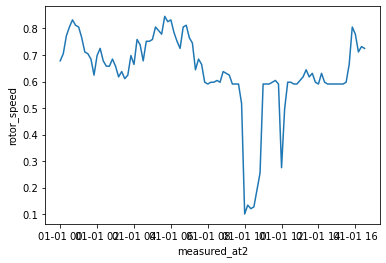

In [106]:
sns.lineplot(data=data.head(100),x="measured_at2",y="rotor_speed")

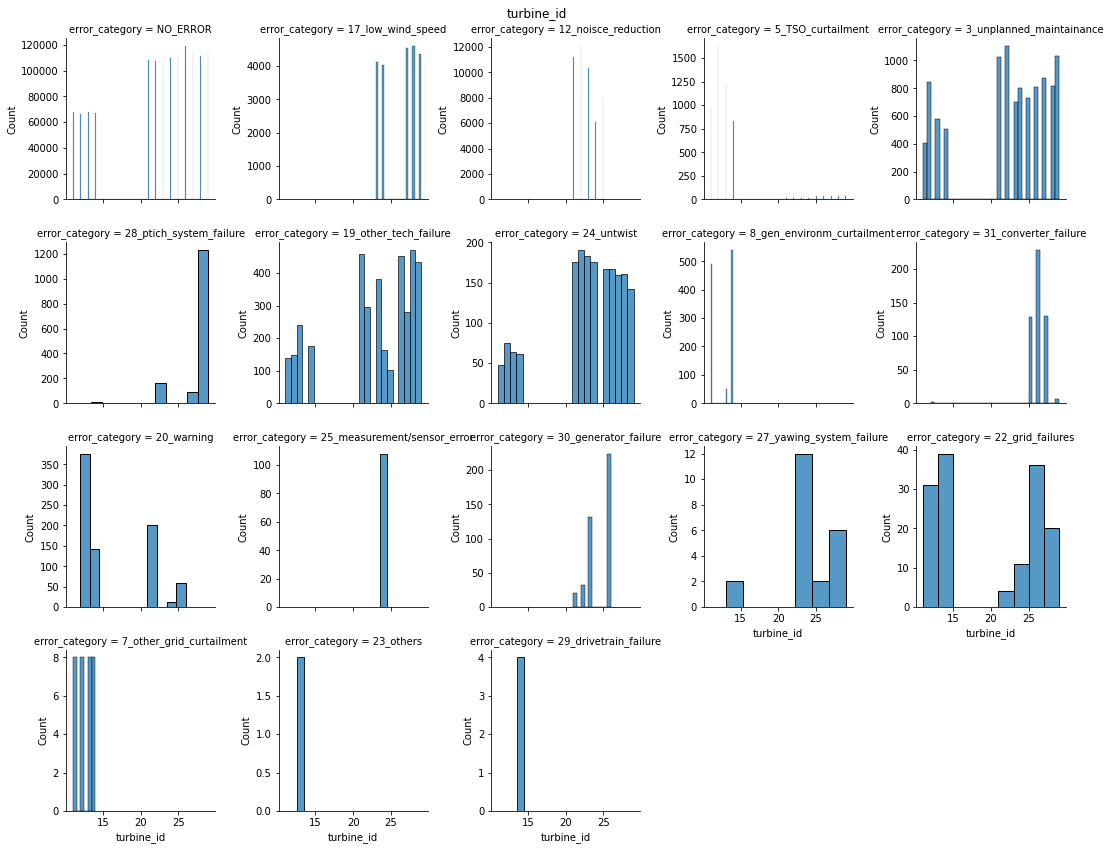

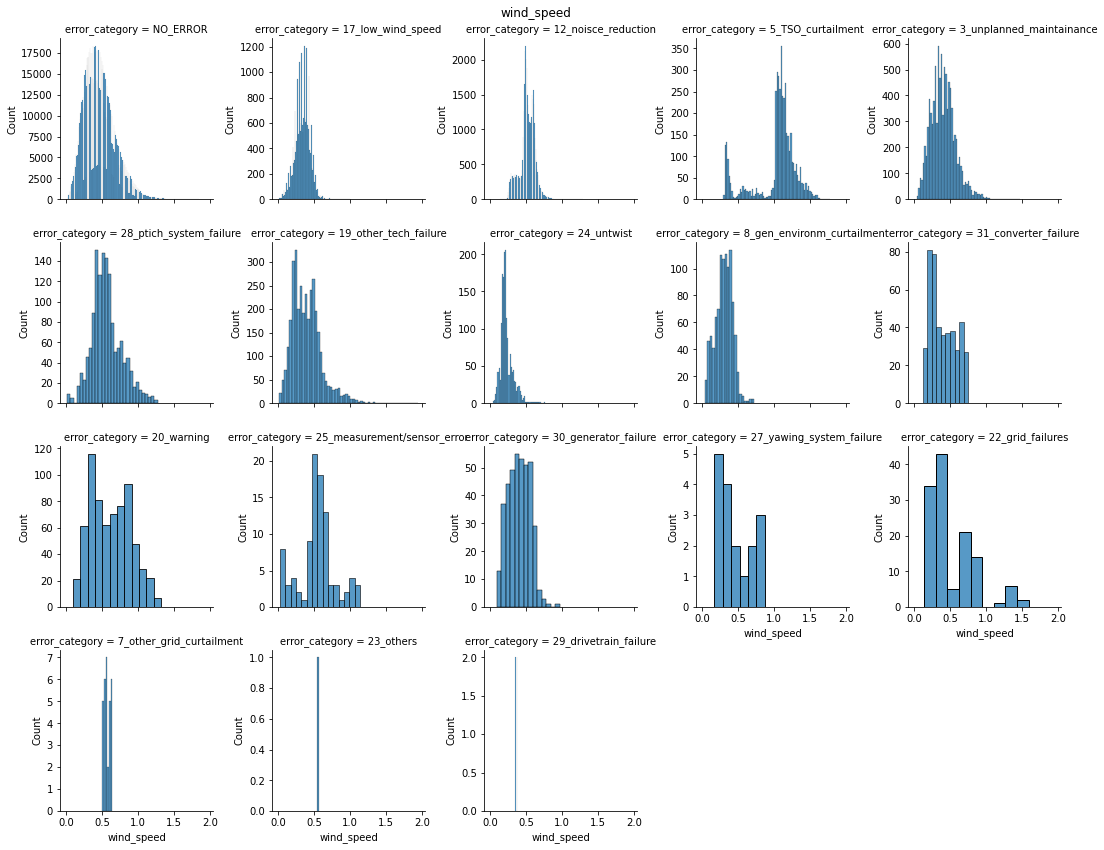

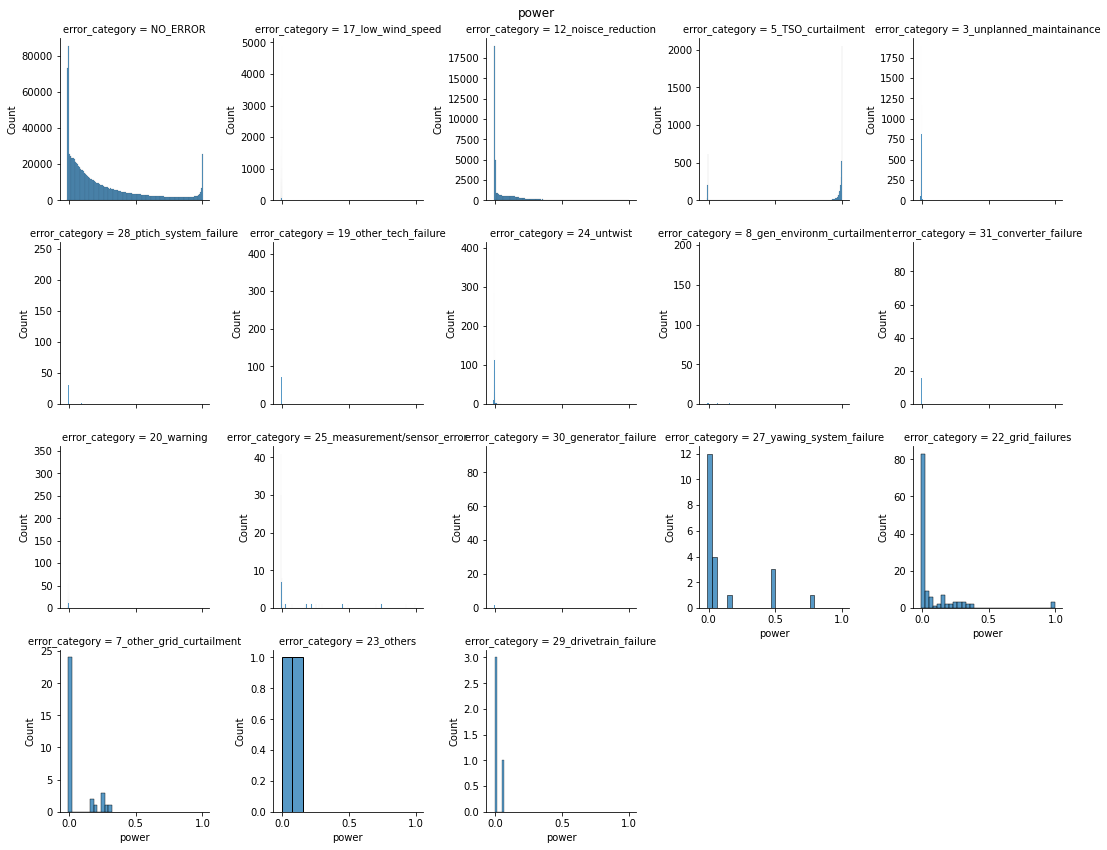

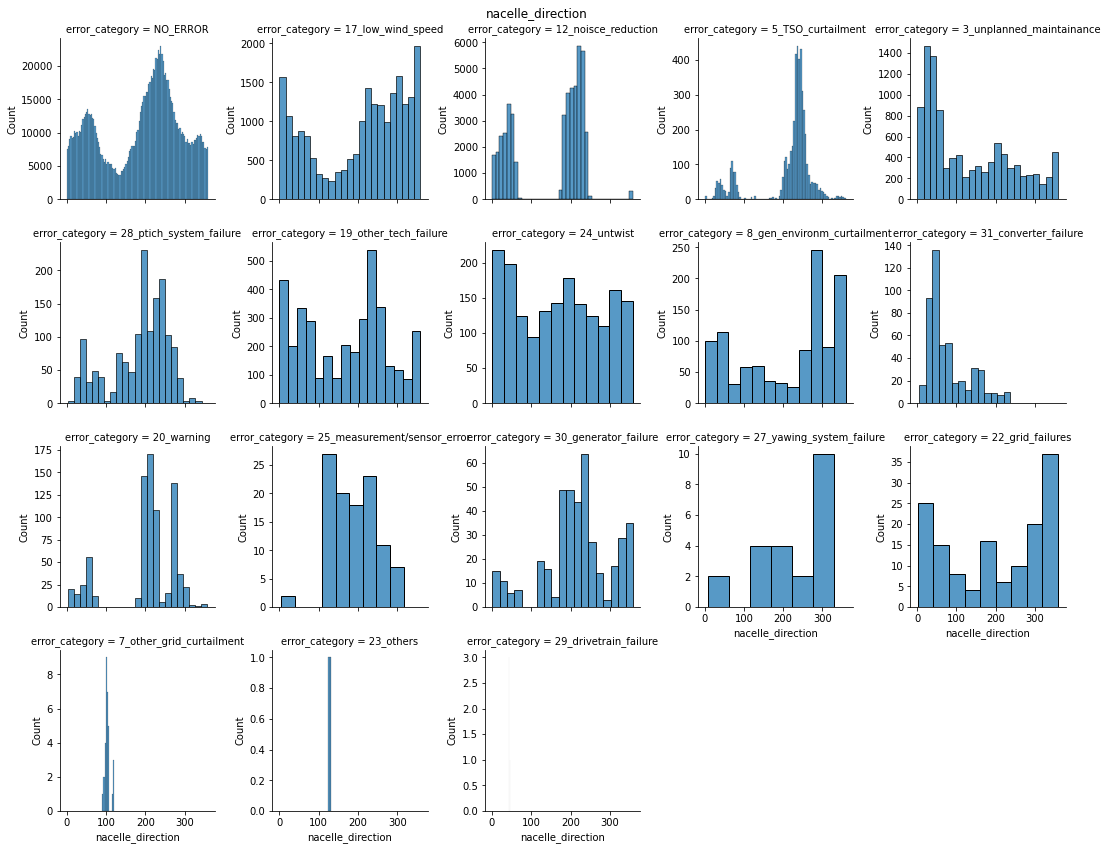

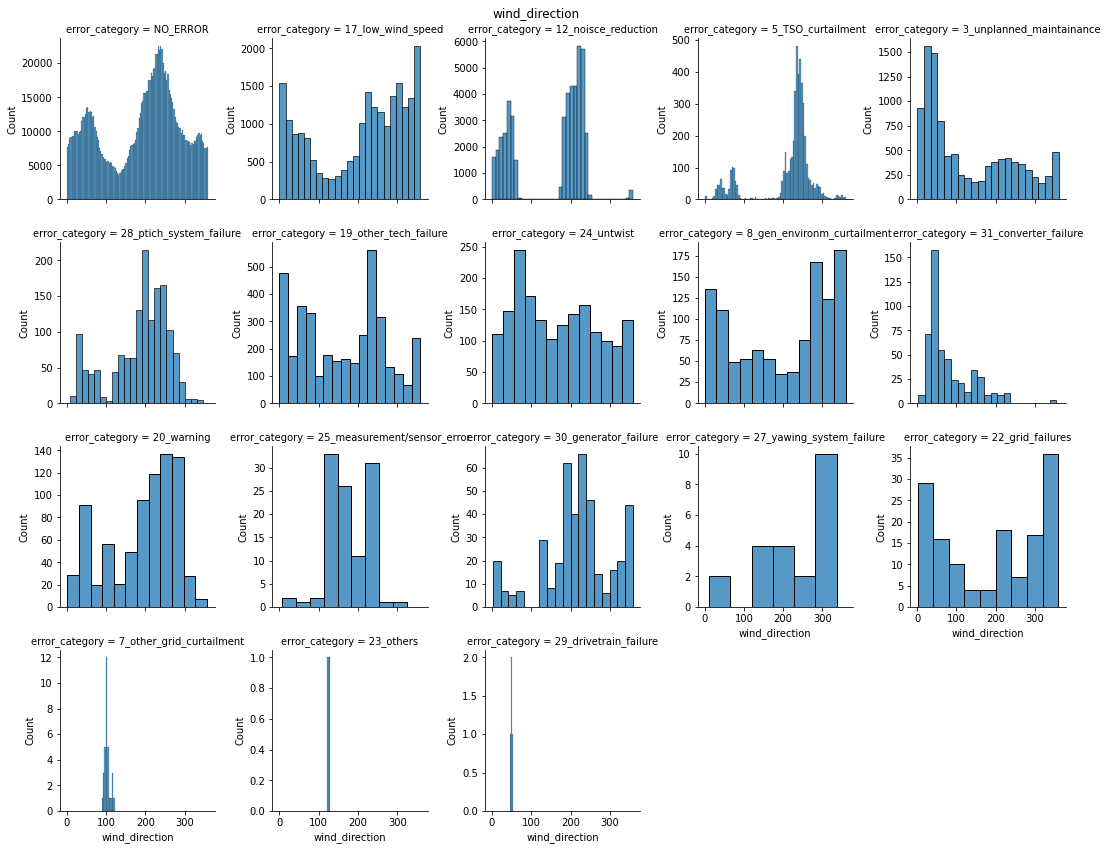

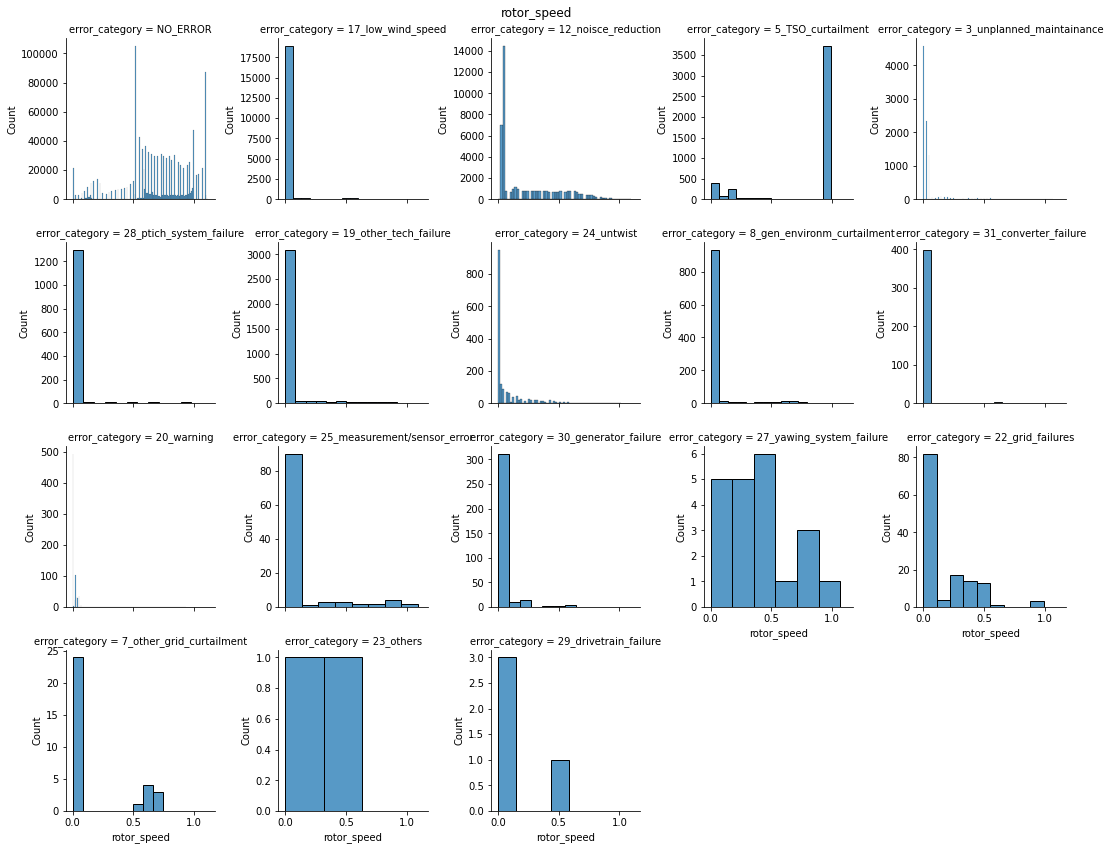

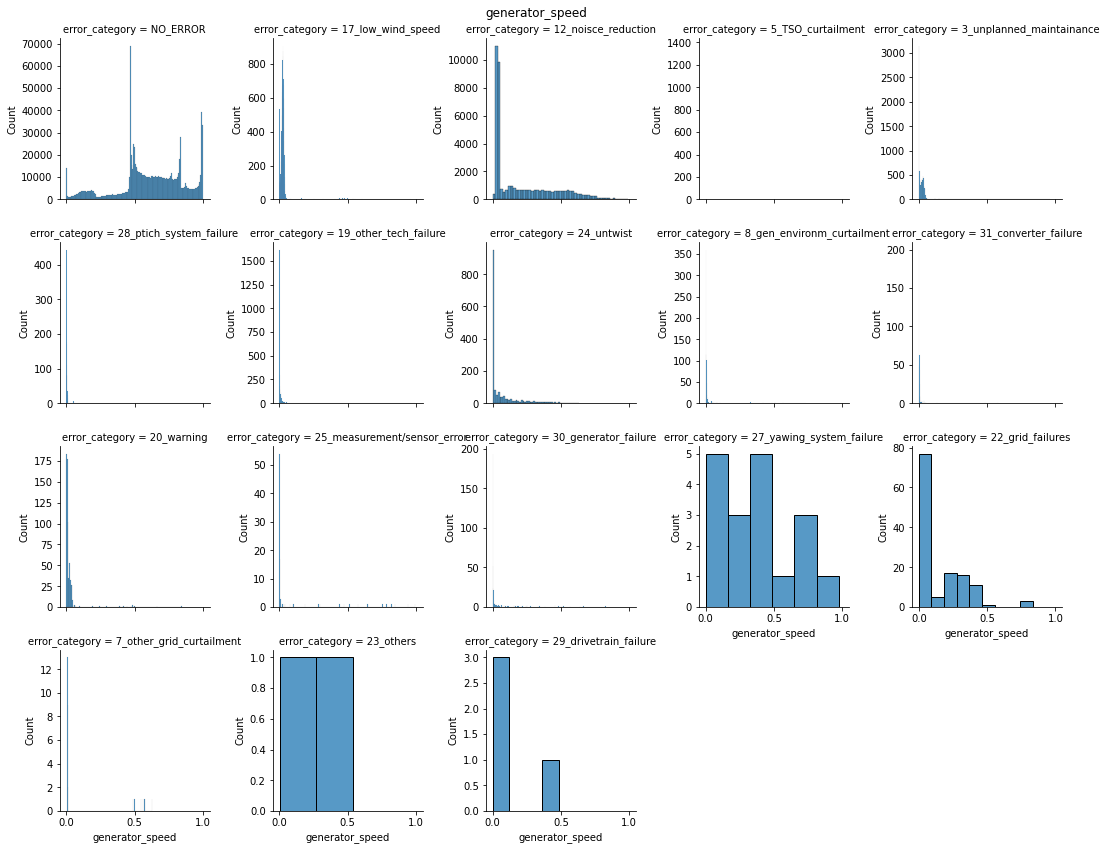

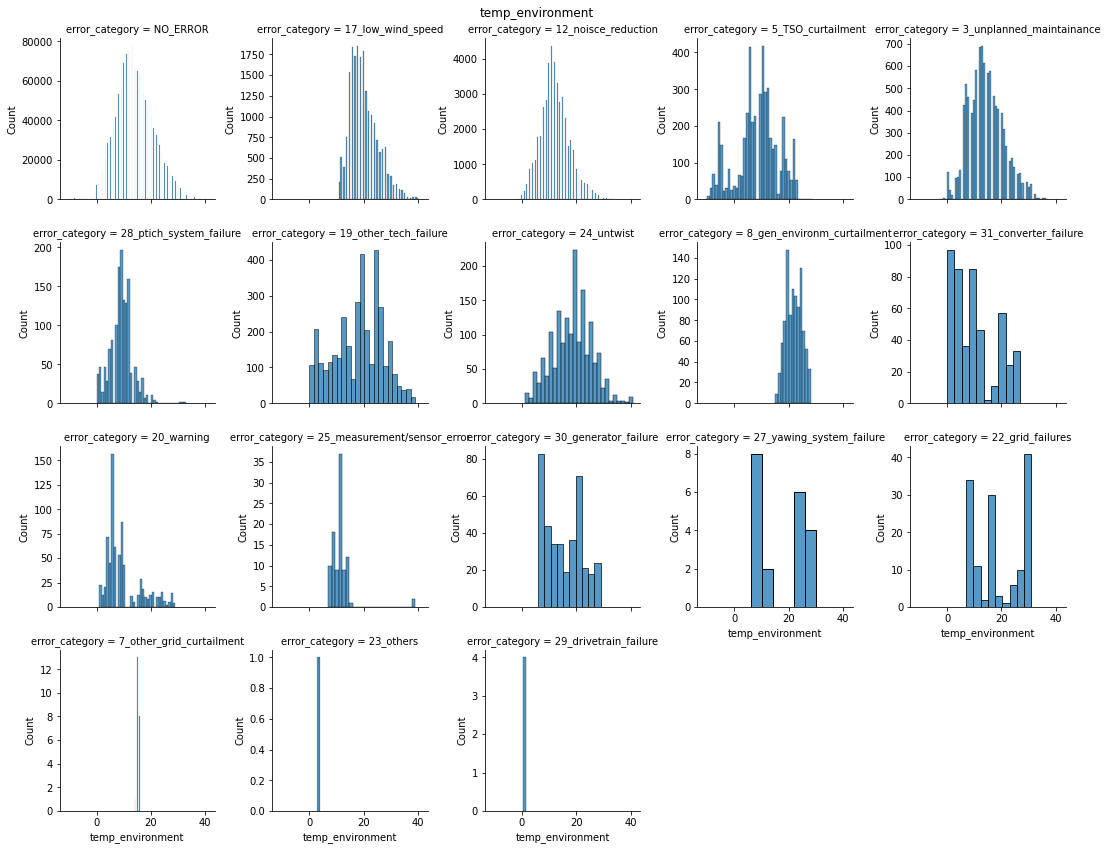

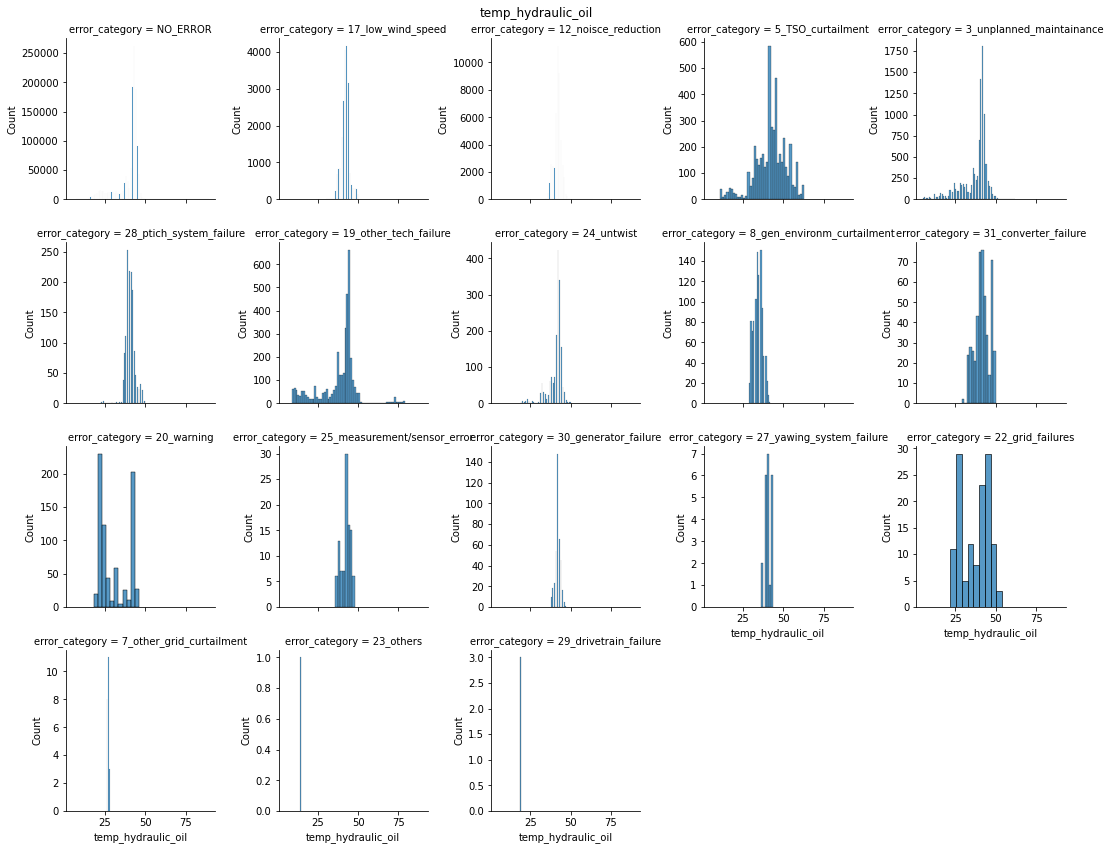

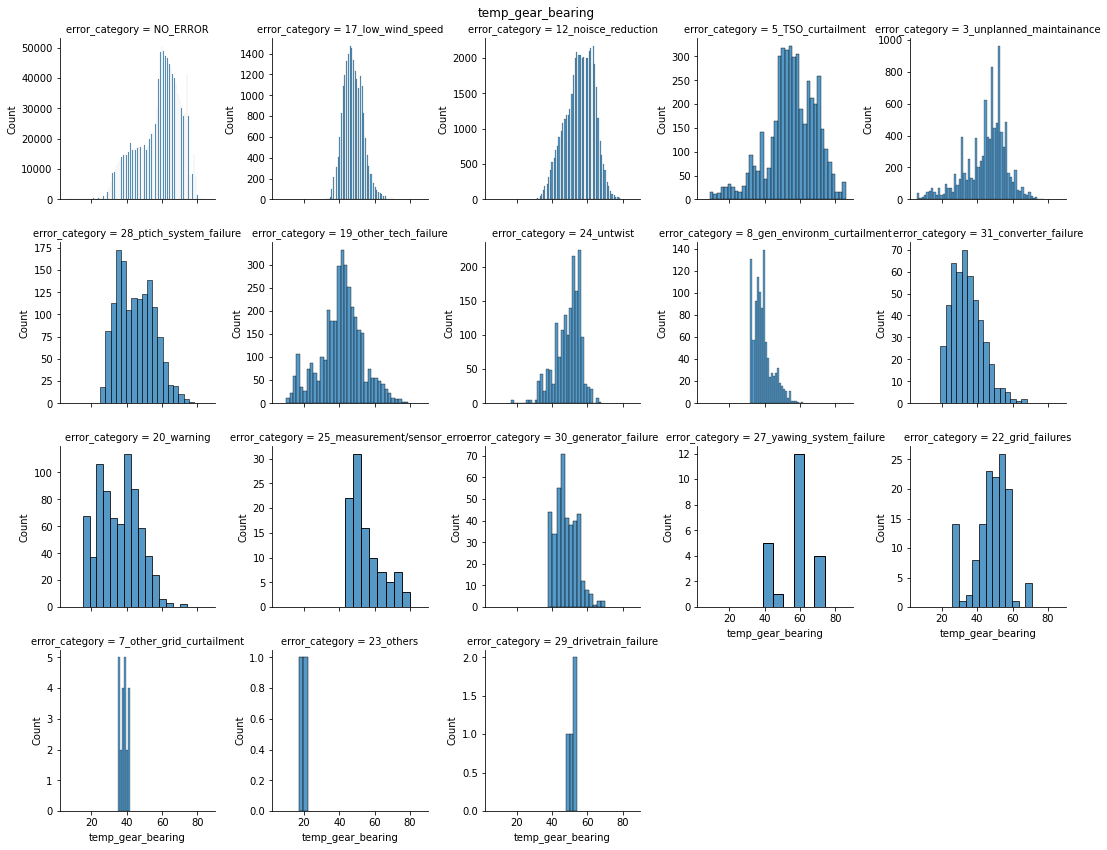

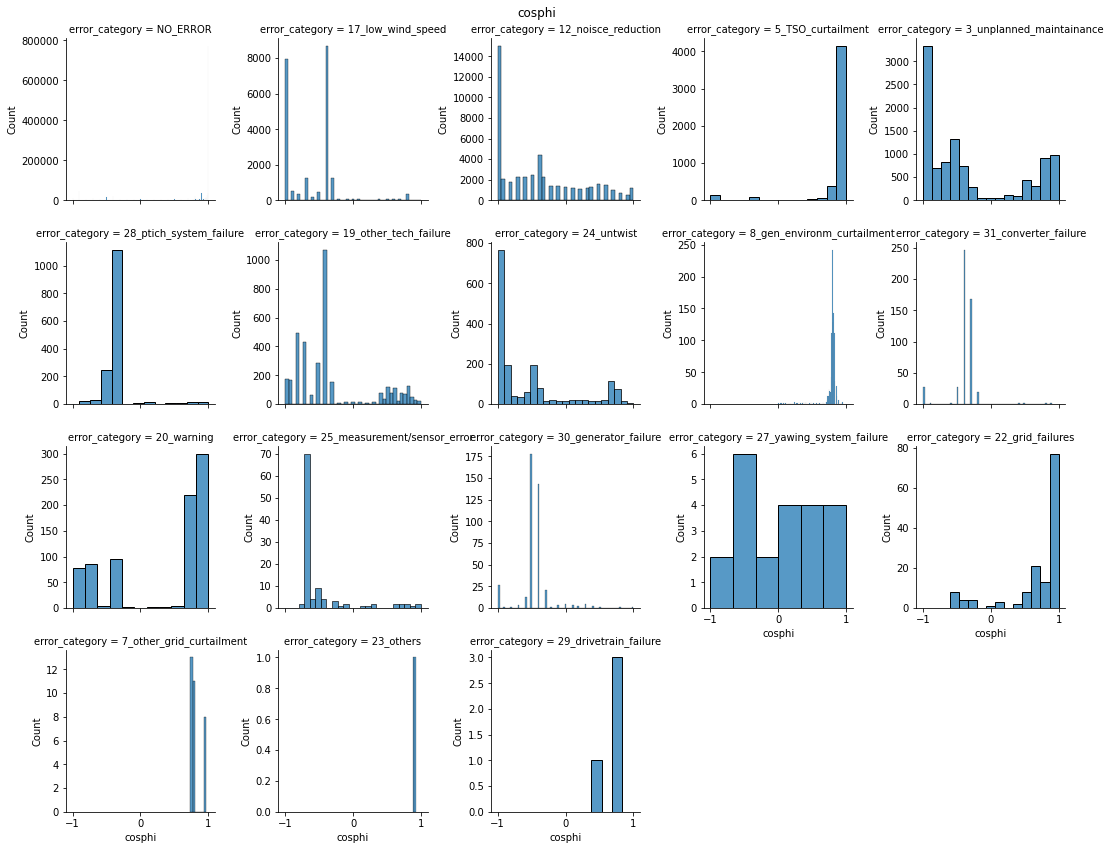

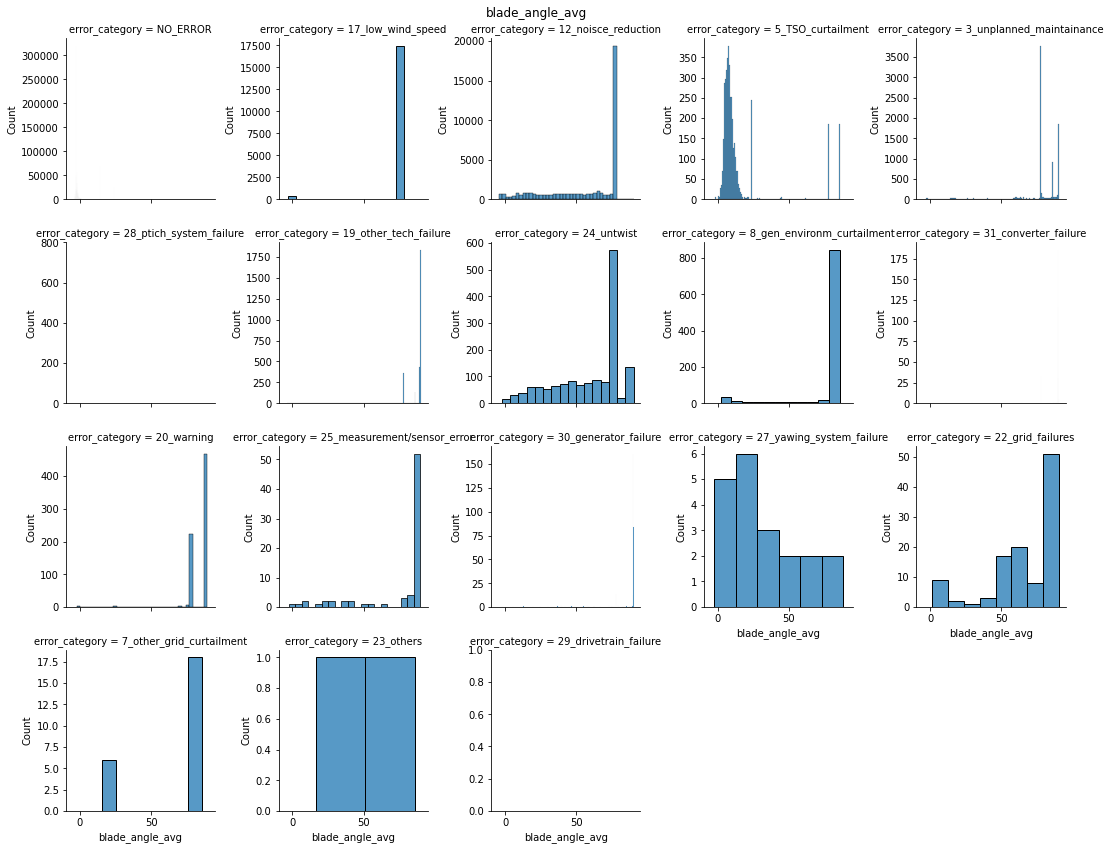

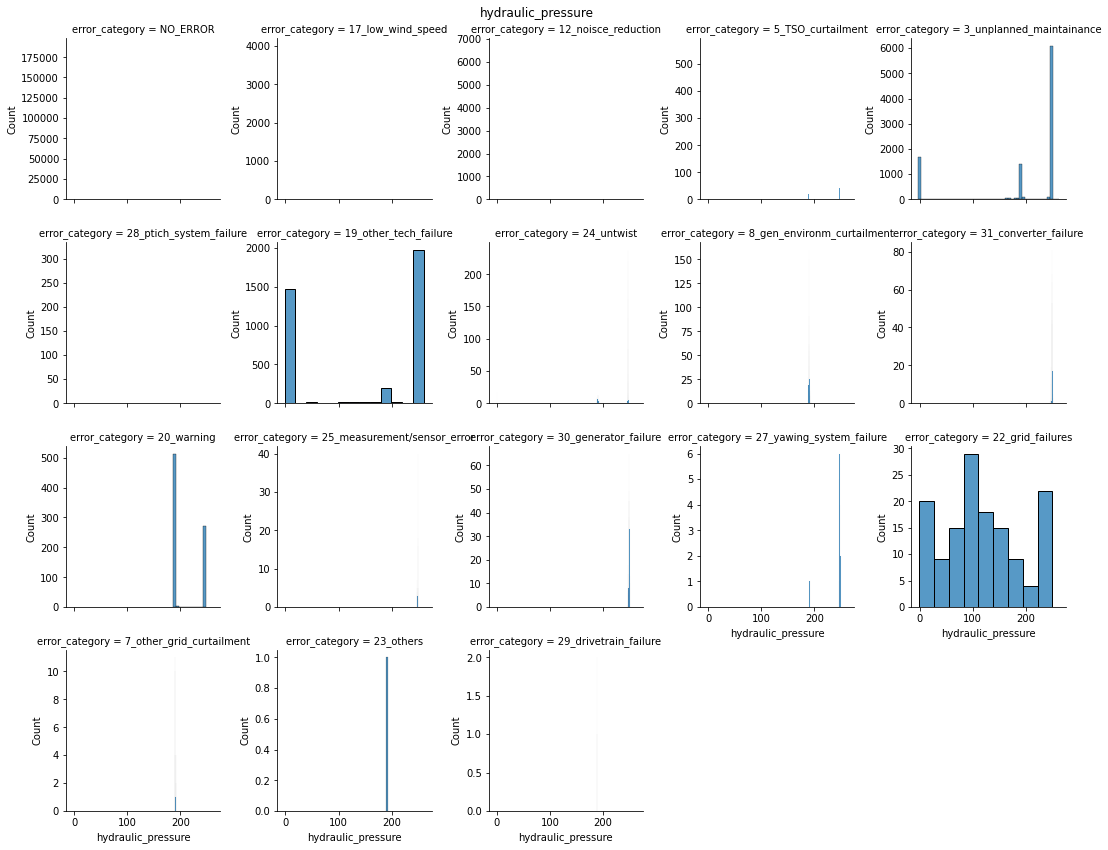

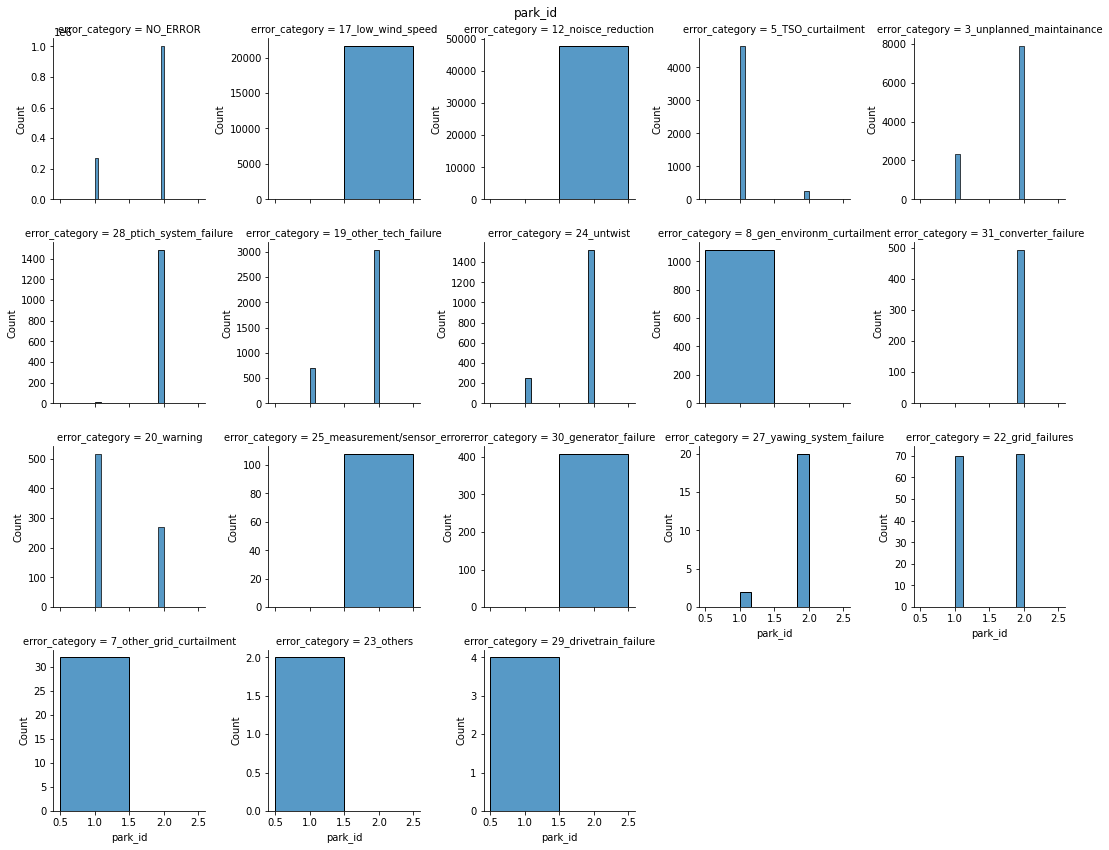

In [114]:


for feature in col_num:
    g = sns.FacetGrid(data3.head(10000000), col="error_category",sharey=False,col_wrap=5)
    g.fig.suptitle(feature)
    g.map(sns.histplot,feature)
    plt.show()

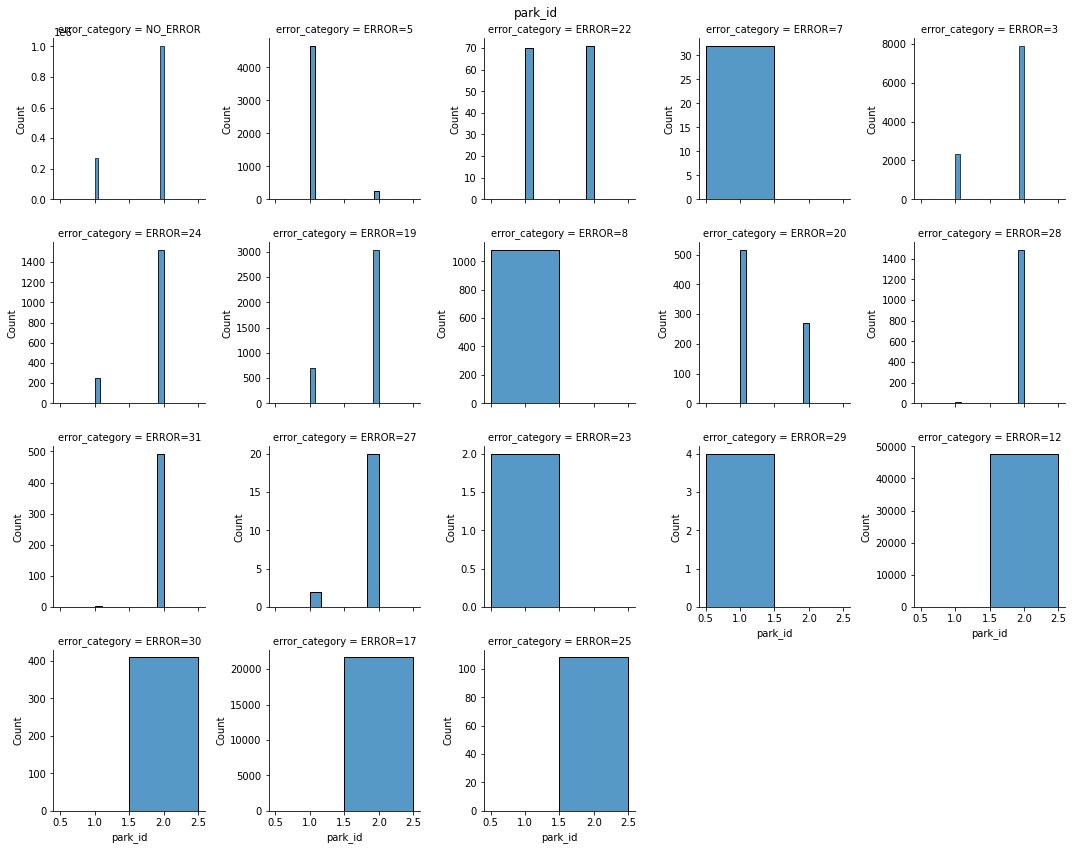

In [115]:

for feature in ["park_id"]:
    g = sns.FacetGrid(data_full, col="error_category",sharey=False,col_wrap=5)
    g.fig.suptitle(feature)
    g.map(sns.histplot,feature)
    plt.show()

['turbine_id' 'measured_at' 'wind_speed' 'power' 'nacelle_direction'
 'wind_direction' 'rotor_speed' 'generator_speed' 'temp_environment'
 'temp_hydraulic_oil' 'temp_gear_bearing' 'cosphi' 'blade_angle_avg'
 'hydraulic_pressure' 'park_id' 'error_category' 'error']
(4893, 17)


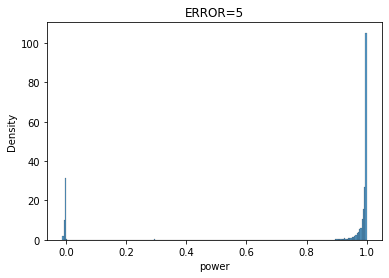

(47724, 17)


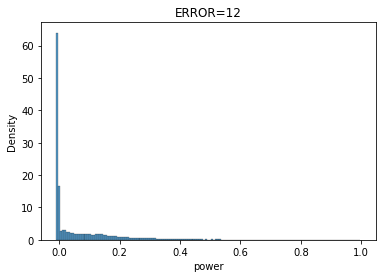

In [68]:
print(data.columns.values)
feature="power"

a=1
match a:
    case 1:
        error_cats=["ERROR=5","ERROR=12"]
    case 2:
        error_cats=["ERROR=12"]
for error_cat in error_cats:
    sns.histplot(data=data[data["error_category"]==error_cat],x=feature,stat="density").set(title=error_cat)
    plt.show()